## Kaggle - Red Wine Quality Regression

This notebook contains the regression pipeline for the Red Wine Quality Kaggle dataset. This file is a python module that can be opened as a notebook using jupytext.

1. [Business/Data Understanding](#1.-Business/Data-Understanding)
2. [Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)
3. [Data Preparation](#3.-Data-Preparation)
4. [Modeling](#4.-Modeling)
5. [Evaluation](#5.-Evaluation)

[References](#References)

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import warnings 
warnings.filterwarnings('ignore')
#from google.colab import files

### 1. Business/Data Understanding

Wine quality refers to the factors that go into producing a wine, as well as the indicators or characteristics that tell you if the wine is of high quality.

When you know what influences and signifies wine quality, you’ll be in a better position to make good purchases. You’ll also begin to recognize your preferences and how your favorite wines can change with each harvest. Your appreciation for wines will deepen once you’re familiar with wine quality levels and how wines vary in taste from region to region.

Some wines are higher-quality than others due to the factors described below. From climate to viticulture to winemaking, a myriad of factors make some wines exceptional and others run-of-the-mill.

### 2. Exploratory Data Analysis

The original dataset is divided into train and validation datasets. 

The exploration is applied to the train dataset, since the validation dataset is supposed to be unseen data. The basic aspects of the train data are shown bellow.

In [2]:
# Run only on the first time
if False:
  raw_df = pd.read_csv('data/winequality-red.csv', header=0)
  train_df, validation_df = train_test_split(
  raw_df,
    test_size=0.2,
    random_state=3
    )

  train_df.to_csv('data/train.csv', header=True, index=True)
  validation_df.to_csv('data/validation.csv', header=True, index=True)

From the dataset info, we can see that the data is really clean, there are no null values. The target variable, quality, is composed by integers, while the features are floats.

In [3]:
train = pd.read_csv('data/train.csv', header=0, index_col=0)
print(f'Dataset shape: {train.shape} \n')
print(train.info())

Dataset shape: (1279, 12) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1279 entries, 606 to 1273
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1279 non-null   float64
 1   volatile acidity      1279 non-null   float64
 2   citric acid           1279 non-null   float64
 3   residual sugar        1279 non-null   float64
 4   chlorides             1279 non-null   float64
 5   free sulfur dioxide   1279 non-null   float64
 6   total sulfur dioxide  1279 non-null   float64
 7   density               1279 non-null   float64
 8   pH                    1279 non-null   float64
 9   sulphates             1279 non-null   float64
 10  alcohol               1279 non-null   float64
 11  quality               1279 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 129.9 KB
None


Using the `describe()` method we can see the mean, standard deviation and the quartiles.

It is also worth noting that the quality only has 6 different values.

In [4]:
print(train['quality'].unique())
train.describe()

[7 5 6 3 8 4]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.357154,0.526771,0.272416,2.521384,0.086697,15.722439,46.295543,0.996766,3.310367,0.657834,10.429815,5.646599
std,1.752126,0.180265,0.195608,1.353377,0.044871,10.382304,33.401788,0.001864,0.156628,0.171037,1.061888,0.815664
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.370000,8.400000,3.000000
25%,7.100000,0.390000,0.100000,1.900000,0.070000,7.000000,21.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,8.000000,0.520000,0.260000,2.200000,0.079000,13.000000,38.000000,0.996800,3.310000,0.620000,10.200000,6.000000
75%,9.300000,0.635000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997850,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


From the correlation plot, on the last row we can see that some features such as **sulphates** and **alcohol** are positive correlated to quality, while others like **volatile acidity** are negative correlated.

<AxesSubplot:>

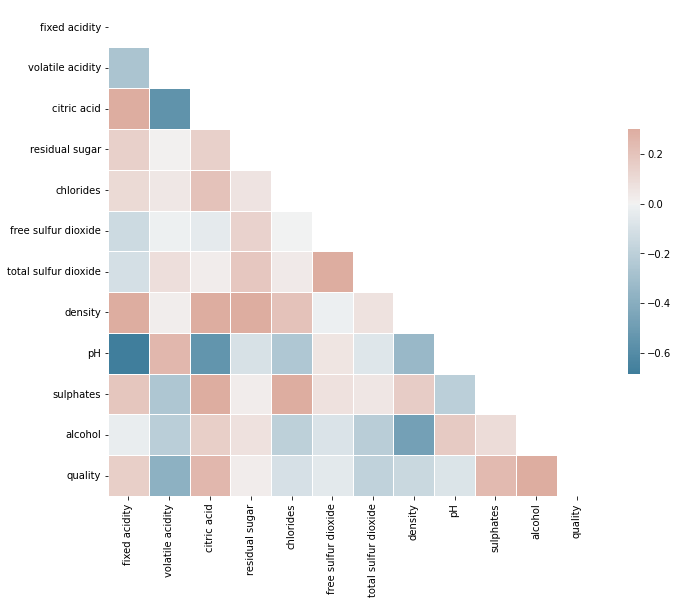

In [5]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
  square=True, linewidths=.5, cbar_kws={"shrink": .5})

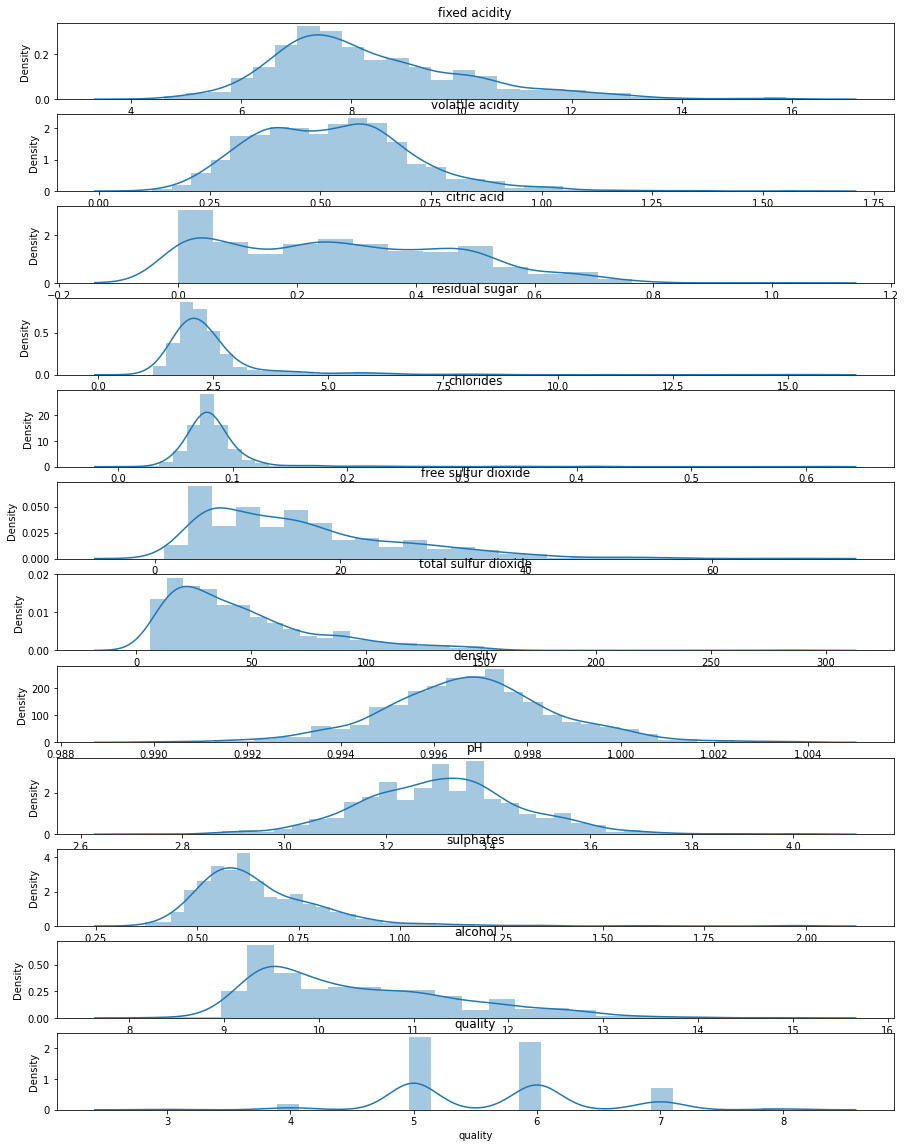

In [6]:
fig, axes = plt.subplots(12, 1, figsize=(15, 20))
for count, col in enumerate(train.columns):
  sns.distplot(train[col], ax=axes[count])
  axes[count].set_title(col)

### 3. Data Preparation

Since the data is already very clean, it is only necessary to scale the features. We are going to use 2 different scalers for preprocessing.

In [7]:
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1:]

standard_scaler_x = StandardScaler().fit(train_x)
standard_train_x = standard_scaler_x.transform(train_x)
standard_scaler_y = StandardScaler().fit(train_y)
standard_train_y = standard_scaler_y.transform(train_y)

minmax_scaler_x = MinMaxScaler().fit(standard_train_x)
scaled_train_x = minmax_scaler_x.transform(standard_train_x)
minmax_scaler_y = MinMaxScaler().fit(standard_train_y)
scaled_train_y = minmax_scaler_y.transform(standard_train_y)
scaled_train_y = scaled_train_y.astype('str')

### 4. Modeling

In [8]:
# Run only for grid search
if False:
  params = {
    'hidden_layer_sizes': [(i, ) for i in range(1, 22, 2)],
    'activation': ('identity', 'logistic', 'tanh', 'relu'),
    'batch_size': [50, 100, 200],
    'max_iter': [200, 400, 800],
    'alpha': [0.0001, 0.01, 1],
    }

  base_mlp = MLPClassifier(random_state=3)
  mlp = GridSearchCV(
    base_mlp,
    params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=5,
    return_train_score=True,
  )
  mlp.fit(scaled_train_x, scaled_train_y)

  results = pd.DataFrame(mlp.cv_results_)
  results = results[['param_hidden_layer_sizes', 'param_activation',
    'param_batch_size', 'param_max_iter', 'param_alpha',
    'mean_test_score', 'rank_test_score','mean_train_score']]
  results.to_csv('mlp_results.csv', index=False)
  # files.download('mlp_results.csv')

The best results are clealy overfitted. To adjust this ranking, one column were added, which represents the distance between test and train errors. Rows which the gap was greater than 5% were dropped from the ranking.

In [9]:
results = pd.read_csv('outputs/mlp_results.csv')
results['test/train'] = \
  results['mean_test_score']/results['mean_train_score']
results[results['test/train'] \
  < 1.05].sort_values(['rank_test_score'])

,param_hidden_layer_sizes,param_activation,param_batch_size,param_max_iter,param_alpha,mean_test_score,rank_test_score,mean_train_score,test/train
950,"(17,)",relu,100,800,0.0001,-0.142417,1,-0.138862,1.025601
923,"(21,)",relu,50,800,0.0001,-0.142508,2,-0.140146,1.016853
983,"(17,)",relu,200,800,0.0001,-0.142919,3,-0.140296,1.018698
916,"(17,)",relu,50,400,0.0001,-0.142975,4,-0.140295,1.019098
1016,"(17,)",relu,50,800,0.0100,-0.143270,5,-0.140236,1.021635
...,...,...,...,...,...,...,...,...,...
1123,"(1,)",relu,100,400,1.0000,-0.208116,1110,-0.208122,0.999969
1122,"(1,)",relu,100,200,1.0000,-0.208116,1110,-0.208122,0.999969
520,"(17,)",logistic,50,400,1.0000,-0.208116,1110,-0.208122,0.999969
515,"(13,)",logistic,50,800,1.0000,-0.208116,1110,-0.208122,0.999969


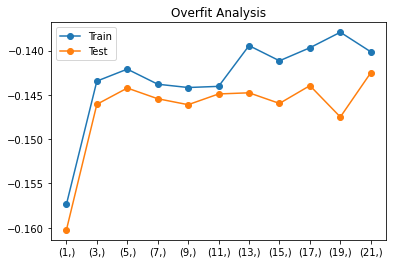

In [10]:
sample = results.query(
  """param_activation == 'relu' \
  & param_batch_size == 50 \
  & param_max_iter == 800 \
  & param_alpha == 0.0001"""
)
plt.plot(
  sample['param_hidden_layer_sizes'],
  sample['mean_train_score'],
  '-o', label='Train')
plt.plot(
  sample['param_hidden_layer_sizes'],
  sample['mean_test_score'],
  '-o', label='Test')
plt.legend()
plt.title('Overfit Analysis')
plt.show()

### 5. Evaluation

In [11]:
validation = pd.read_csv('data/validation.csv',
  header=0, index_col=0)

validation_x = validation.iloc[:,:-1]
validation_y = validation.iloc[:,-1:]
validation_y.reset_index(drop=True, inplace=True)

standard_validation_x = standard_scaler_x.transform(validation_x)
scaled_validation_x = minmax_scaler_x.transform(standard_validation_x)

In [12]:
mlp = MLPClassifier(
  hidden_layer_sizes=(21,),
  activation='relu',
  batch_size=50,
  max_iter=800,
  alpha=0.0001,
  random_state=3
)
mlp.fit(scaled_train_x, scaled_train_y)
results = standard_scaler_y.inverse_transform(
  minmax_scaler_y.inverse_transform(
    mlp.predict(scaled_validation_x).reshape((320,1))
  )
)

In [20]:
validation_y['pred'] = pd.Series(results.astype('int').reshape((320,)))
validation_y.to_csv('outputs/predictions.csv', index=False)

print(accuracy_score(
  validation_y['quality'],
  validation_y['pred'])
)

0.65


### References

[1] [Wine Quality Introduction](https://www.jjbuckley.com/wine-knowledge/blog/the-4-factors-and-4-indicators-of-wine-quality/1009) 